In [30]:
using Images, TestImages, ImageIO, ImageMagick, ImageView, Colors
using StatsBase, Statistics, LinearAlgebra, Plots, Random
using Flux

In [31]:
NN = 10

10

In [32]:
#make a 'noisy' square
function noisySquare()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( (rr >= 3 && rr <= 7) && (cc >= 3 && cc <= 7) )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisySquare (generic function with 1 method)

In [33]:
#function 'noisy cross'
function noisyCross()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( rr == 5 || cc == 5 )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisyCross (generic function with 1 method)

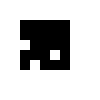

In [34]:
Gray.(noisySquare())

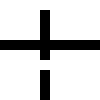

In [35]:
Gray.(noisyCross())

In [36]:
img_Num = 100

100

In [37]:
size( noisyCross() )

(10, 10)

In [38]:
sq_cr_data_WHCN = Array{Float32, 4}(undef,10,10,1,200);
display( size(sq_cr_data_WHCN) )
[ sq_cr_data_WHCN[:,:,:,ii] = noisySquare() for ii in 1:img_Num ]
[ sq_cr_data_WHCN[:,:,:,ii] = noisyCross() for ii in img_Num+1:img_Num*2 ];

(10, 10, 1, 200)

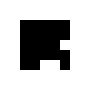

In [39]:
Gray.( sq_cr_data_WHCN[:,:,1,1] )

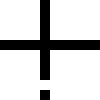

In [40]:
Gray.( sq_cr_data_WHCN[:,:,1,101] )

In [41]:
enc1 = Chain( Conv((3,3),1=>2) , Conv((3,3),2=>4,relu) , AdaptiveMeanPool((1,1)) , Flux.flatten )

Chain(
  Conv((3, 3), 1 => 2),                 # 20 parameters
  Conv((3, 3), 2 => 4, relu),           # 76 parameters
  AdaptiveMeanPool((1, 1)),
  Flux.flatten,
)                   # Total: 4 arrays, 96 parameters, 1.109 KiB.

In [47]:
#enc1[3]( enc1[2]( enc1[1](sq_cr_data_WHCN) ) )

In [50]:
dec1 = Chain(Dense(4=>25),x->reshape(x,5,5,1,:),ConvTranspose((2,2),1=>1,stride=2,pad=SamePad()) )

Chain(
  Dense(4 => 25),                       # 125 parameters
  var"#15#16"(),
  ConvTranspose((2, 2), 1 => 1, stride=2),  # 5 parameters
)                   # Total: 4 arrays, 130 parameters, 1008 bytes.

In [54]:
#dec1[3]( dec1[2]( dec1[1]( rand(4,1) ) ) )

(4, 2)---(10, 10, 1, 2)


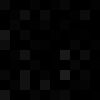

In [55]:
res1 = enc1( sq_cr_data_WHCN[:,:,:,1:2] )
res2 = dec1( res1 )
println( size(res1) ,"---", size(res2) )
Gray.( res2[:,:,1,1] )

In [56]:
enc1_dec1 = Chain( enc1 , dec1 )

Chain(
  Chain(
    Conv((3, 3), 1 => 2),               # 20 parameters
    Conv((3, 3), 2 => 4, relu),         # 76 parameters
    AdaptiveMeanPool((1, 1)),
    Flux.flatten,
  ),
  Chain(
    Dense(4 => 25),                     # 125 parameters
    var"#15#16"(),
    ConvTranspose((2, 2), 1 => 1, stride=2),  # 5 parameters
  ),
)                   # Total: 8 arrays, 226 parameters, 2.672 KiB.

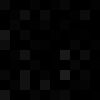

In [57]:
Gray.( enc1_dec1(sq_cr_data_WHCN[:,:,:,1:2])[:,:,1,1] )

In [58]:
Y = vcat( repeat(["S"],img_Num) , repeat(["C"],img_Num) );
print(size(Y))

(200,)

In [61]:
data = Flux.DataLoader( (sq_cr_data_WHCN,sq_cr_data_WHCN) , batchsize=10 , shuffle=true ) 

20-element DataLoader(::Tuple{Array{Float32, 4}, Array{Float32, 4}}, shuffle=true, batchsize=10)
  with first element:
  (10×10×1×10 Array{Float32, 4}, 10×10×1×10 Array{Float32, 4},)

In [62]:
length( enc1_dec1 )

2

In [63]:
enc1_dec1[2][3]

ConvTranspose((2, 2), 1 => 1, stride=2)  # 5 parameters

In [64]:
enc1_dec1[2][3].weight

2×2×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.145405   0.799617
  0.210445  -0.436957

In [65]:
opt = Flux.setup( Flux.Adam(0.001) , enc1_dec1 );

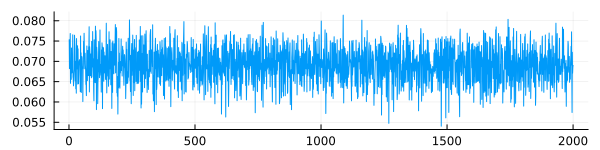

In [83]:
losses = []

for epoch in 1:100
    
    for ( x , y ) in data   
        
        loss_tmp, grads = Flux.withgradient( enc1_dec1 ) do model
                
            y_hat = model( x )
            loss = Flux.mse( y_hat , y )
            return loss
            
        end     
        Flux.update!( opt , enc1_dec1 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses ,  legend=false , size=(600,150) )
display(p1)

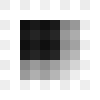

In [84]:
Gray.( enc1_dec1(sq_cr_data_WHCN[:,:,:,1:2])[:,:,1,1] )

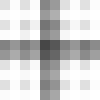

In [85]:
Gray.( enc1_dec1(sq_cr_data_WHCN[:,:,:,101:102])[:,:,1,1] )

In [86]:
enc_output_sqr = enc1(sq_cr_data_WHCN[:,:,:,1:2])[:,1]
enc_output_sqr

4-element Vector{Float32}:
 4.4098535
 4.9667015
 5.419794
 1.9585366

In [87]:
enc_output_cr = enc1(sq_cr_data_WHCN[:,:,:,101:102])[:,1]
enc_output_cr

4-element Vector{Float32}:
 4.105055
 4.2574997
 5.1097584
 3.3681862

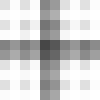

In [88]:
Gray.( dec1(enc_output_cr) )[:, :, 1, 1]

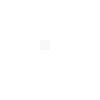

In [89]:
composite_sqr_cr = enc_output_sqr .+ enc_output_cr
Gray.( dec1(composite_sqr_cr) )[:, :, 1, 1]

In [99]:
res = pixel_shuffle( enc1[3]( enc1[2]( enc1[1](sq_cr_data_WHCN) )) , 2 )
display( size( res ) )
Gray.( res[:,:,:,111][1] )

(2, 2, 1, 200)

In [193]:
enc2 = Chain( Conv((3,3),1=>2) , 
                Conv((3,3),2=>4,relu) , 
                Conv((2,2),4=>4,relu) ,
                AdaptiveMeanPool((1,1)) , 
               x-> pixel_shuffle(x,2), 
                 BatchNorm(1) )

Chain(
  Conv((3, 3), 1 => 2),                 # 20 parameters
  Conv((3, 3), 2 => 4, relu),           # 76 parameters
  Conv((2, 2), 4 => 4, relu),           # 68 parameters
  AdaptiveMeanPool((1, 1)),
  var"#63#64"(),
  BatchNorm(1),                         # 2 parameters, plus 2
)         # Total: 8 trainable arrays, 166 parameters,
          # plus 2 non-trainable, 2 parameters, summarysize 1.969 KiB.

In [194]:
dec2 = Chain(  ConvTranspose((3,3),1=>1,stride=2,pad=SamePad() ) ,
                 ConvTranspose((3,3),1=>1,stride=2,pad=SamePad() ) ,
               ConvTranspose((3,3),1=>1,stride=2,pad=SamePad() ) ,
                   ConvTranspose((3,3),1=>1,stride=2,pad=SamePad() ) ,
             AdaptiveMeanPool((10,10)) )

Chain(
  ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
  ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
  ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
  ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
  AdaptiveMeanPool((10, 10)),
)                   # Total: 8 arrays, 40 parameters, 1.594 KiB.

In [195]:
dec2[4]( dec2[3]( dec2[2]( dec2[1]( res[:,:,:,111:112] ) ) ) );

In [196]:
dec2( res[:,:,:,111:112] )

10×10×1×2 Array{Float32, 4}:
[:, :, 1, 1] =
  0.0414437    0.023995     0.0329272   …   0.0123165    0.0130908
  0.0545406    0.00195588   0.0136158      -0.0192708   -0.0324573
  0.0128873   -0.0117646   -0.021844       -0.00880035  -0.01353
 -0.0355897   -0.0167868   -0.0102681       0.0155849    0.0100034
 -0.0363467    0.00422231  -0.0146866      -0.0127757   -0.0289444
  0.0256819    0.0432757    0.0124863   …   0.00470782   0.00664066
  0.0805138    0.0596085   -0.00153044     -0.0262758   -0.0239167
  0.0561943    0.0241904   -0.0710527      -0.0296457   -0.029802
 -0.00847568  -0.0405367    0.0262983       0.0334395    0.0256223
 -0.0217567   -0.0164752    0.0720911       0.0205371   -0.0229977

[:, :, 1, 2] =
  0.0428282    0.0251379    0.0336227   …   0.0123434    0.0133245
  0.0568484    0.00287063   0.0134175      -0.02082     -0.0338752
  0.0138682   -0.0119055   -0.0227786      -0.00930121  -0.0138303
 -0.0366601   -0.0180732   -0.00954531      0.0168734    0.0107284
 -0.

In [197]:
enc2_dec2 = Chain( enc2 , dec2 )

Chain(
  Chain(
    Conv((3, 3), 1 => 2),               # 20 parameters
    Conv((3, 3), 2 => 4, relu),         # 76 parameters
    Conv((2, 2), 4 => 4, relu),         # 68 parameters
    AdaptiveMeanPool((1, 1)),
    var"#63#64"(),
    BatchNorm(1),                       # 2 parameters, plus 2
  ),
  Chain(
    ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
    ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
    ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
    ConvTranspose((3, 3), 1 => 1, pad=(1, 0, 1, 0), stride=2),  # 10 parameters
    AdaptiveMeanPool((10, 10)),
  ),
)         # Total: 16 trainable arrays, 206 parameters,
          # plus 2 non-trainable, 2 parameters, summarysize 4.844 KiB.

In [198]:
opt = Flux.setup( Flux.Adam(0.001) , enc2_dec2 );

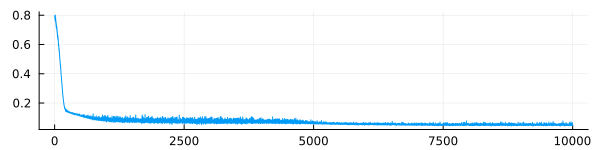

In [199]:
losses = []

for epoch in 1:500
    
    for ( x , y ) in data   
        
        loss_tmp, grads = Flux.withgradient( enc2_dec2 ) do model
                
            y_hat = model( x )
            loss = Flux.mse( y_hat , y )
            return loss
            
        end     
        Flux.update!( opt , enc2_dec2 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses ,  legend=false , size=(600,150) )
display(p1)

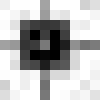

In [200]:
Gray.( enc2_dec2(sq_cr_data_WHCN[:,:,:,1:2])[:,:,1,1] )

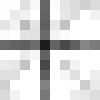

In [201]:
Gray.( enc2_dec2(sq_cr_data_WHCN[:,:,:,101:102])[:,:,1,1] )

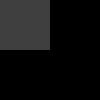

In [202]:
Gray.( enc2( sq_cr_data_WHCN[:,:,:,101:102] )[:,:,1,1] )

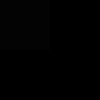

In [203]:
Gray.( enc2( sq_cr_data_WHCN[:,:,:,1:2] )[:,:,1,1] )

In [204]:
enc2( sq_cr_data_WHCN[:,:,:,1:2] )[:,:,1,1]

2×2 Matrix{Float32}:
  0.011492   -0.0407668
 -0.0847735  -2.85084

In [205]:
enc2( sq_cr_data_WHCN[:,:,:,101:102] )[:,:,1,1]

2×2 Matrix{Float32}:
  0.246732  -0.472649
 -0.4507    -1.13577